In [1]:
#import data manipulation libraries
import pandas as pd
import numpy as np

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import logging
import logging
logging.basicConfig(filename='model.log',level=logging.INFO, filemode='w', format='%(asctime)s - %(levelname)s - %(message)s')

#import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
url="https://raw.githubusercontent.com/Frisk516/Student_performance_MLModel/refs/heads/main/student_performance_dataset.csv"
df=pd.read_csv(url,sep=',')
df.sample(frac=1)

,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail
585,S400,Male,37,88.987939,74,Bachelors,Yes,Yes,64,Pass
330,S244,Male,20,88.928597,89,PhD,No,Yes,61,Pass
703,S492,Male,14,84.658761,78,PhD,Yes,No,50,Fail
124,S280,Female,39,89.504232,67,PhD,No,Yes,64,Pass
362,S304,Female,30,55.713365,78,Masters,Yes,No,50,Fail
...,...,...,...,...,...,...,...,...,...,...
352,S270,Male,26,64.396481,53,High School,No,Yes,50,Fail
616,S244,Male,20,88.928597,89,PhD,No,Yes,61,Pass
85,S476,Female,23,65.729828,91,Bachelors,No,No,58,Fail
642,S437,Female,25,88.545569,87,High School,No,No,61,Pass


In [3]:
#checking for null values
df.isnull().sum()

Student_ID                    0
Gender                        0
Study_Hours_per_Week          0
Attendance_Rate               0
Past_Exam_Scores              0
Parental_Education_Level      0
Internet_Access_at_Home       0
Extracurricular_Activities    0
Final_Exam_Score              0
Pass_Fail                     0
dtype: int64

In [4]:
#splitting data into numerical and categorical
numerical=df.select_dtypes(exclude=['object'])
categorical=df.select_dtypes(include=['object'])

In [5]:
#performing EDA
from collections import OrderedDict
stats=[]
for i in numerical.columns:
    numerical_stats=OrderedDict({
        'feature':i,
        'mean':numerical[i].mean(),
        'median':numerical[i].median(),
        'mode':numerical[i].mode()[0],
        'std':numerical[i].std(),
        'min':numerical[i].min(),
        'max':numerical[i].max()
    })
    stats.append(numerical_stats)
report=pd.DataFrame(stats)


#checking outliers
outlier_label = []
for col in report['feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # LW : Lower Whisker Line
    UW = Q3 + 1.5 * IQR   # UW : Upper Whisker Line
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

report["Outlier Comment"] = outlier_label

report

,feature,mean,median,mode,std,min,max,Outlier Comment
0,Study_Hours_per_Week,26.132768,27.000000,35.00000,8.877727,10.00000,39.000000,No Outliers
1,Attendance_Rate,78.107722,79.363046,84.68588,13.802802,50.11697,99.967675,No Outliers
2,Past_Exam_Scores,77.871469,79.000000,64.00000,14.402739,50.00000,100.000000,No Outliers
3,Final_Exam_Score,58.771186,59.500000,50.00000,6.705877,50.00000,77.000000,No Outliers


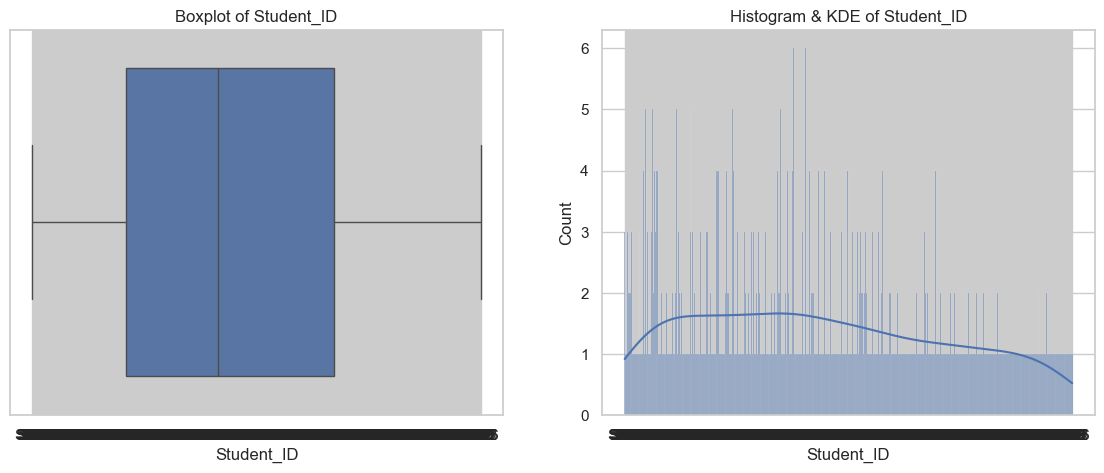

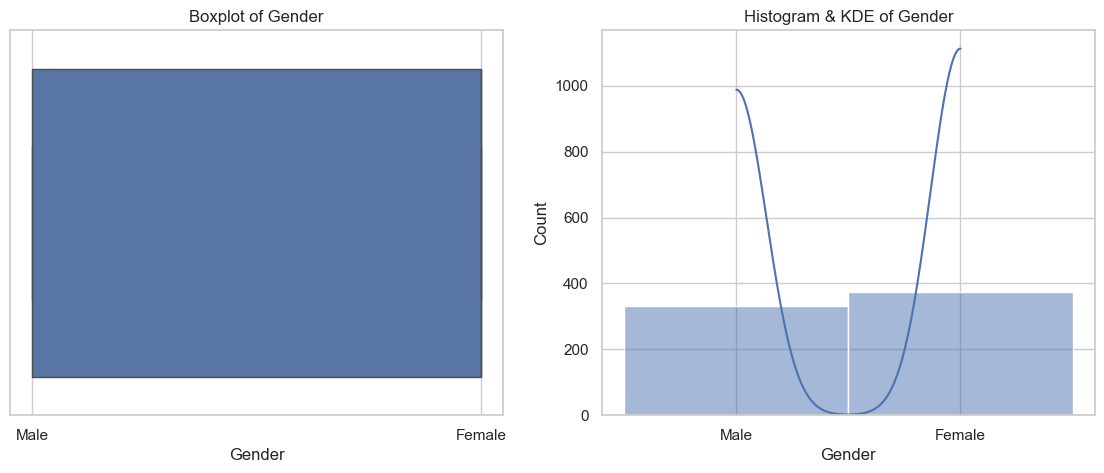

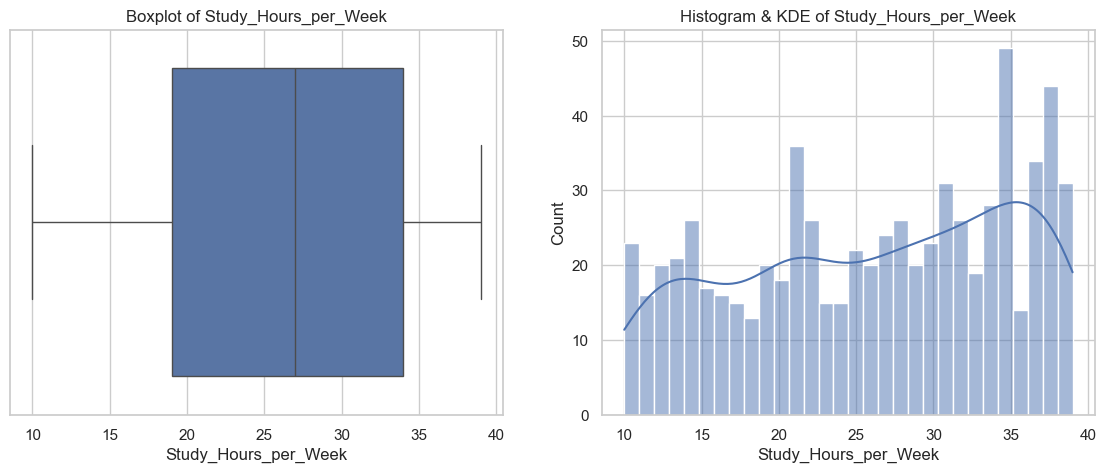

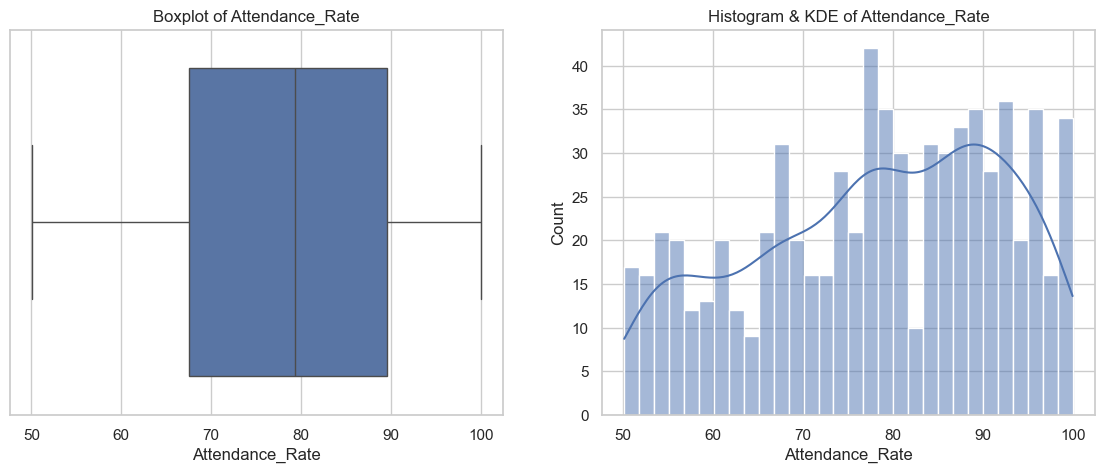

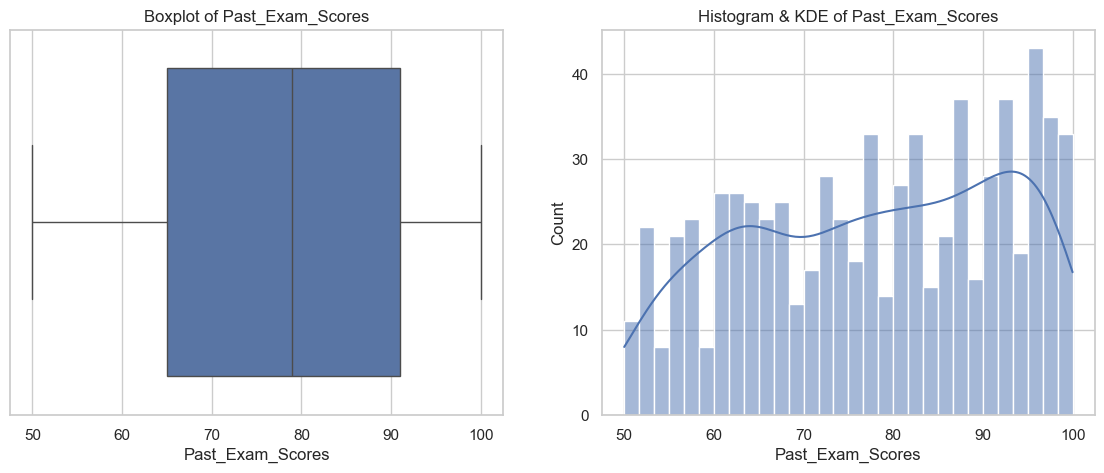

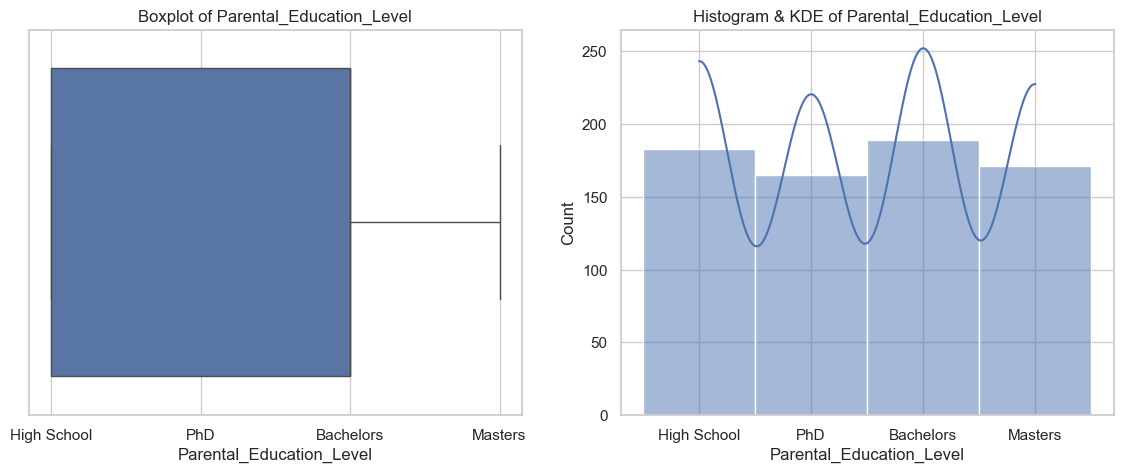

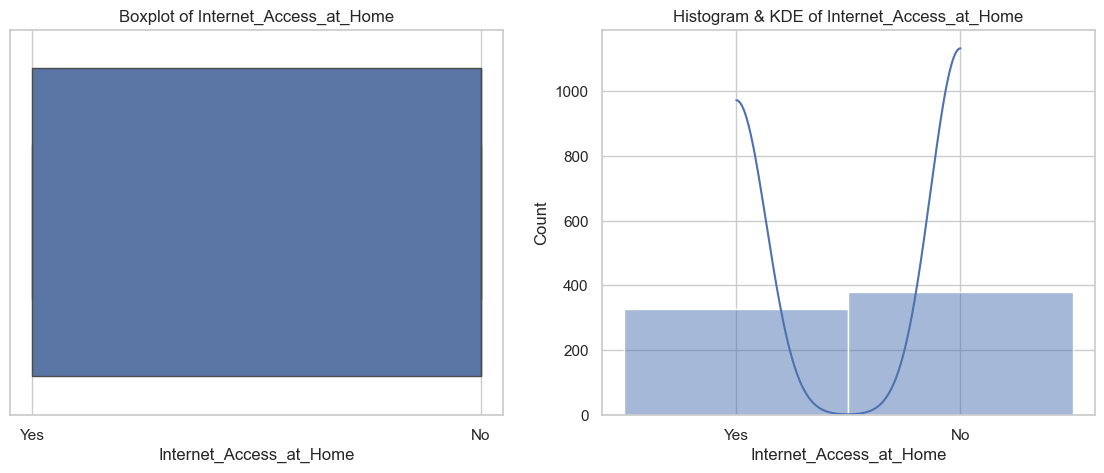

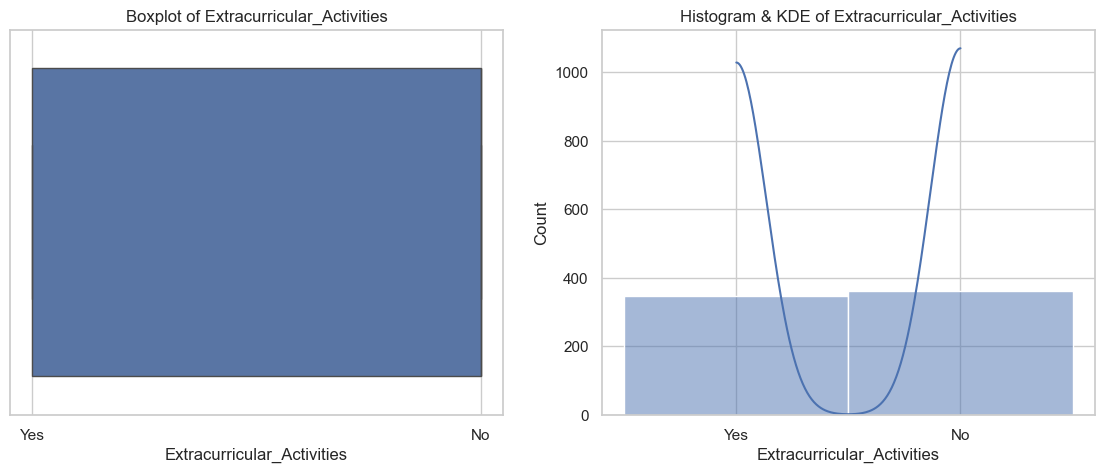

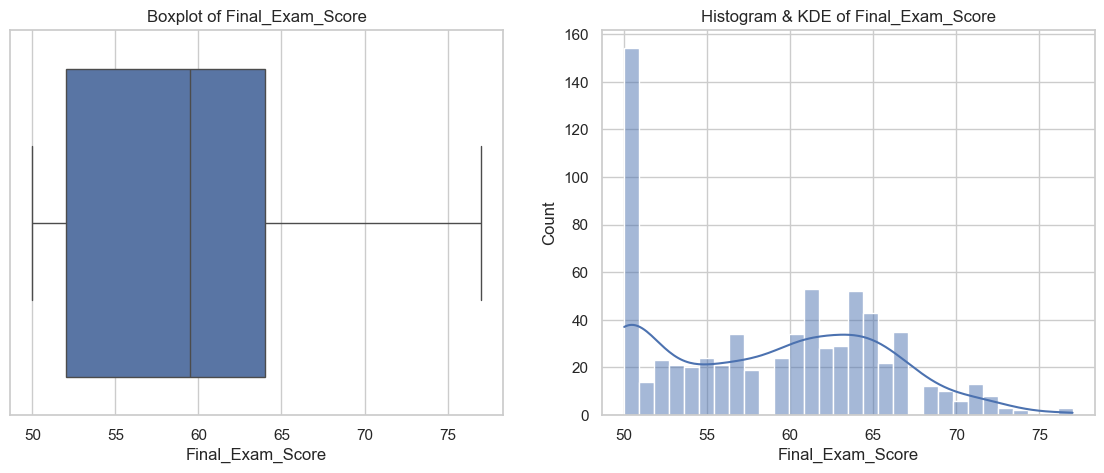

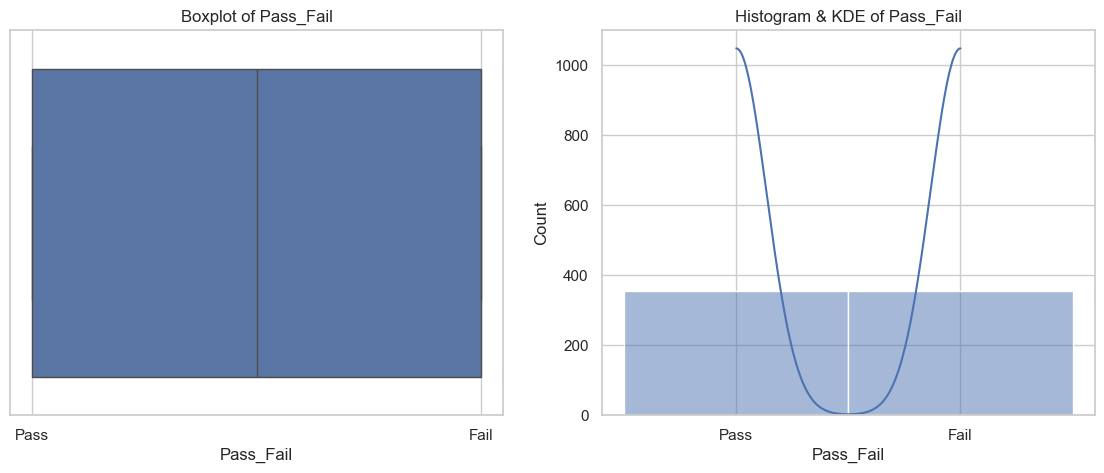

In [6]:
sns.set(style="whitegrid")

# Plot boxplots and bell curves for each numerical feature
for col in df:
    plt.figure(figsize=(14, 5))
    
    # Boxplot (shows outliers as points beyond whiskers)
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    
    # Bell curve: histogram + KDE (to check distribution shape)
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram & KDE of {col}')
    
    plt.show()

In [7]:
#using labelencoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])
df['Parental_Education_Level']=le.fit_transform(df['Parental_Education_Level'])
df['Internet_Access_at_Home']=le.fit_transform(df['Internet_Access_at_Home'])
df['Extracurricular_Activities']=le.fit_transform(df['Extracurricular_Activities'])
df['Student_ID']=le.fit_transform(df['Student_ID'])


In [8]:
#encoding the target column where yes=1 and no=0
df['Pass_Fail'] = df['Pass_Fail'].map({'Pass': 1, 'Fail': 0})

In [9]:
#checking if target column is balanced
df['Pass_Fail'].value_counts()

Pass_Fail
1    354
0    354
Name: count, dtype: int64

In [11]:
#train test split to prevent data leak

from sklearn.model_selection import train_test_split
X=df.drop('Pass_Fail',axis=1)
y=df['Pass_Fail']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=7)

In [12]:
#dataset has no outliers but is non-normally distributed
#using minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [13]:
#using logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

#using metrics to evaluate model performance
from sklearn.metrics import accuracy_score,classification_report

accuracy_score_LR=accuracy_score(y_test,y_pred)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       108
           1       0.94      0.96      0.95       105

    accuracy                           0.95       213
   macro avg       0.95      0.95      0.95       213
weighted avg       0.95      0.95      0.95       213

